In [1]:
# # 基于 PysLoc-DeepONet 的旅行时间模拟与测试示例
# 
# 本示例使用 PyTorch 实现了预测三维速度模型下的旅行时间场。
# 
# 主要功能：
# 
# 1. **数据生成**：
#    - 读取速度模型和台站数据，构建 3D 网格；
#    - 生成训练数据（随机震源位置、随机采样点）和测试数据（随机或指定震源，全网格）。
# 
# 2. **训练阶段**：
#    - 训练数据中的台站旅行时输入统一与第一个台站的旅行时做差后输入网络；
#    - 采用 Eikonal 方程约束和数据约束（MSE）共同训练；
#    - 使用 `tqdm` 美化训练进度显示。
# 
# 3. **测试阶段**：
#    - 第一次测试：随机选取 5 个震源位置；
#    - 第二次测试：使用指定经纬度坐标 `(lat=54.347937, lon=-117.245207, depth=3.285)` 测试；




In [2]:
# ## 1. 导入必要的库


In [3]:
from scipy.interpolate import RegularGridInterpolator
import pyekfmm as fmm
import torch.nn as nn
import torch.autograd as autograd
from tqdm import trange
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from obspy import read
import torch
from scipy.stats import qmc  # 统计库中的拉丁超立方采样

In [1]:
# 代码编号

level_Code_id = 1

In [5]:
#训练参数
n_sources=1000
n_samples=100000
num_epochs=200
grid_size=65

In [6]:
# 设置随机种子以确保可重复性
np.random.seed(42)
torch.manual_seed(42)

# 设置计算设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("使用设备:", device)


使用设备: cuda


In [7]:
# 在训练前预先初始化 CUDA 上下文
dummy = torch.zeros(1, device=device)
torch.cuda.synchronize()


In [8]:
# ## 2. 数据生成部分
# 
# 数据生成包括：  
# 1. 读取速度模型和台站数据；  
# 2. 构建 3D 网格；  
# 3. 生成训练数据和测试数据。


In [9]:
# 设置fig保存路径

fig_save_dir = os.path.join("Try_zy_level","fig", f"fig_{level_Code_id}")

print(fig_save_dir)
# 确保目录存在
os.makedirs(fig_save_dir, exist_ok=True)

Try_zy_level\fig\fig_1


In [10]:
# ### 2.1 准备基础数据


In [11]:
import numpy as np

def generate_velocity_model():
    dz = 0.05  # 网格间距 50m
    z_max = 2.5 # 最大深度 4km
    nz = int(z_max / dz) + 1  # 计算深度网格点数

    z_coords = np.linspace(0, z_max, nz)  # 生成深度坐标
    velocity = 2.5 + z_coords  # 速度随深度均匀增加，每千米增加1km/s

    return z_coords, velocity

def generate_geophone_coordinates(num_per_branch=17, domain_size=5.0, margin=0.5):
    """
    生成位于地表的检波器坐标，呈“十”字排布。
    检波器分布范围固定为 [margin, domain_size - margin]，默认 [1, 4] km，
    检波器在该范围内等间隔分布，水平和垂直各布置 num_per_branch 个，中心交叉处仅保留一个点。

    :param num_per_branch: 每个方向上的检波器数量（应为奇数），默认 17
    :param domain_size: 水平区域大小（km），默认 5 km
    :param margin: 检波器距边缘距离（km），默认 1 km
    :return: (N, 3) 数组，包含所有检波器的 (x, y, z) 坐标
    """
    center = domain_size / 2.0  # 区域中心，默认为 2.5 km
    start = margin
    end = domain_size - margin
    # 根据给定的个数计算等间距
    spacing = (end - start) / (num_per_branch - 1)

    # 垂直排列：x 固定在中心，y 从 start 到 end
    x_vert = np.full(num_per_branch, center)
    y_vert = np.linspace(start, end, num_per_branch)
    z_vert = np.zeros(num_per_branch)

    # 水平排列：y 固定在中心，x 从 start 到 end
    x_horiz = np.linspace(start, end, num_per_branch)
    y_horiz = np.full(num_per_branch, center)
    z_horiz = np.zeros(num_per_branch)

    # 合并两组数据
    coords_vert = np.column_stack((x_vert, y_vert, z_vert))
    coords_horiz = np.column_stack((x_horiz, y_horiz, z_horiz))
    combined = np.vstack((coords_vert, coords_horiz))
    # 去掉重复的中心点
    combined_unique = np.unique(combined, axis=0)

    return combined_unique

def prepare_base_data(grid_size=53):
    """
    构建速度模型和台站数据，并生成3D网格。
    :param grid_size: 总检波器个数（“十”字阵列总数），应为奇数
    """
    z_coords, velocity = generate_velocity_model()
    # 根据总数计算每个方向上的检波器数量（十字阵列总数 = 2*n - 1）
    num_per_branch = (grid_size + 1) // 2
    domain_size = 3.0  # 水平区域 5km × 5km
    stations = generate_geophone_coordinates(num_per_branch=num_per_branch,domain_size = 3.0, margin=0.5)


    x_min, y_min = 0, 0
    x_max, y_max = domain_size, domain_size

    dx = dy = 0.05  # 网格间距 50m
    nx, ny = int(x_max / dx) + 1, int(y_max / dy) + 1

    x_coords = np.linspace(x_min, x_max, nx)
    y_coords = np.linspace(y_min, y_max, ny)

    # 生成三维速度模型，假设速度仅随深度变化
    velocity_3d = np.tile(velocity, (nx, ny, 1)).astype(np.float32)

    return {
        'velocity_3d': velocity_3d,
        'x_coords': x_coords,
        'y_coords': y_coords,
        'z_coords': z_coords,
        'stations': stations,
        'model_bounds': (x_min, x_max, y_min, y_max, z_coords[0], z_coords[-1]),
    }


# # 测试代码，当检波器数量较大时（例如53），仍保证分布范围在1~4 km内
# base_data = prepare_base_data(grid_size=53)
# print("检波器坐标：")
# print(base_data['stations'])
# for key, value in base_data.items():
#     print(f"{key}: {type(value)}")


In [12]:
# 调用函数并获取结果
data = prepare_base_data(grid_size=grid_size)

# 访问返回的数据
velocity_3d = data['velocity_3d']
x_coords = data['x_coords']
y_coords = data['y_coords']
z_coords = data['z_coords']
stations = data['stations']
model_bounds = data['model_bounds']


# 打印速度模型的形状
print(velocity_3d.shape)
print(x_coords[0],x_coords[-1])
print(y_coords[0],y_coords[-1])
print(z_coords[0],z_coords[-1])
print(stations.shape)

(61, 61, 51)
0.0 3.0
0.0 3.0
0.0 2.5
(65, 3)


In [1]:

def plot_velocity_model(velocity_model, x_coords, y_coords, z_coords, receivers=None,
                        save=False, save_dir="fig", Code_id="Model001", alpha=0.7,
                        show_fig=True, levels=100, font_size = 16,num_ticks=3, cmap="jet"):
    """
    绘制速度模型的三维切片图，并显示检波器位置（如果提供）。

    参数:
    - velocity_model: 3D numpy 数组，表示速度模型 (nx, ny, nz)
    - x_coords, y_coords, z_coords: 1D numpy 数组，分别表示 X, Y, Z 方向的坐标 (km)
    - receivers: 2D numpy 数组 (N, 3)，表示 N 个检波器的 (x, y, z) 坐标 (km)，可选
    - save: 是否保存图像 (默认 False)
    - save_dir: 保存目录 (默认 "fig")
    - Code_id: 文件命名标识 (默认 "Model001")
    - alpha: 透明度 (默认 0.7)
    - show_fig: 是否显示图像 (默认 True)
    - levels: 等高线级别数量 (默认 100)
    - num_ticks: 轴刻度数量 (默认 5)
    - cmap: 颜色映射方案 (默认 "jet")

    输出:
    - 若 save=True，则图像将以 PNG 格式保存在 `save_dir`
    """
    # 转换速度模型格式为 (ny, nx, nz) 以便绘制
    vm = np.transpose(velocity_model, (1, 0, 2))

    # 构造三维网格
    X, Y, Z = np.meshgrid(x_coords, y_coords, z_coords)

    # 颜色映射参数
    vmin = vm.min()
    vmax = vm.max()
    kw = {
        'vmin': vmin,
        'vmax': vmax,
        'levels': np.linspace(vmin, vmax, levels),
        'cmap': cmap
    }

    # 统一字体大小和间隔
    font_size = 16
    label_pad = 10  # 轴标签与刻度之间的间隔

    # 设定刻度数量
    x_ticks = np.linspace(0, X.max(), num_ticks)
    y_ticks = np.linspace(0, Y.max(), num_ticks)
    z_ticks = np.linspace(Z.max(), 0, num_ticks)  # 反转Z轴方向
    cbar_ticks = np.linspace(vmin, vmax, num_ticks)  # 颜色条刻度

    # 创建 3D 图形
    fig, ax = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={'projection': '3d'})

    # 关闭背景和网格
    ax.set_facecolor('none')
    ax.grid(False)

    # 绘制不同平面
    ax.contourf(X[:, :, 0], Y[:, :, 0], vm[:, :, 0], zdir='z', offset=0, alpha=alpha, **kw)
    ax.contourf(X[0, :, :], vm[0, :, :], Z[0, :, :], zdir='y', offset=0, alpha=alpha, **kw)
    cs3 = ax.contourf(vm[:, -1, :], Y[:, -1, :], Z[:, -1, :], zdir='x', offset=X.max(), alpha=alpha, **kw)

    # 设置坐标轴范围
    ax.set_xlim(0, X.max())
    ax.set_ylim(0, Y.max())
    ax.set_zlim(Z.max(), 0)

    # 设置轴标签和刻度
    ax.set_xlabel('X (km)', fontsize=font_size, labelpad=label_pad)
    ax.set_ylabel('Y (km)', fontsize=font_size, labelpad=label_pad)
    ax.set_zlabel('Z (km)', fontsize=font_size, labelpad=label_pad)

    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_zticks(z_ticks)

    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.tick_params(axis='z', which='major', labelsize=font_size)

    # 添加 colorbar，并减少刻度数量
    cbar = fig.colorbar(cs3, ax=ax, fraction=0.02, pad=0.1, format='%4.2f')
    cbar.set_ticks(cbar_ticks)  # 设定 colorbar 的刻度
    cbar.ax.tick_params(labelsize=font_size)  # colorbar 刻度字体大小
    cbar.set_label('Velocity (km/s)', fontsize=font_size, labelpad=label_pad)  # colorbar 标签间隔

    # 绘制检波器（如果有）
    if receivers is not None:
        ax.scatter(receivers[:, 0], receivers[:, 1], receivers[:, 2],
                   color='red', marker='v', s=50, label='Geophone')
        ax.legend(fontsize=font_size)

    plt.tight_layout()

    # 保存图像
    if save:
        full_save_dir = os.path.join(save_dir, f"fig_{Code_id}_new")
        os.makedirs(full_save_dir, exist_ok=True)
        save_path = os.path.join(full_save_dir, f"Velocity_Model_{Code_id}_0.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"切片图像已保存至: {save_path}")

    # 显示图像
    if show_fig:
        plt.show()

# 调用绘图函数，显示模型及检波器示意图
plot_velocity_model(velocity_3d, x_coords, y_coords, z_coords,
                    receivers=stations, save=True, Code_id=level_Code_id, alpha=1, show_fig=True, levels=100)


NameError: name 'velocity_3d' is not defined

In [14]:
def generate_training_dataset(n_sources=100, n_samples=10000,grid_size=grid_size):
    """
    生成训练数据集，包括随机震源位置、采样点和台站旅行时间。
    """
    base_data = prepare_base_data(grid_size=grid_size)
    x_coords = base_data['x_coords']
    y_coords = base_data['y_coords']
    z_coords = base_data['z_coords']
    velocity_3d = base_data['velocity_3d']
    stations = base_data['stations']
    x_min, x_max, y_min, y_max, z_min, z_max = base_data['model_bounds']

    # 创建速度插值器
    velocity_interp = RegularGridInterpolator(
        (x_coords, y_coords, z_coords),
        velocity_3d,
        bounds_error=False,
        fill_value=np.nan
    )

    # 随机生成震源位置
    # 生成拉丁超立方随机样本
    sampler = qmc.LatinHypercube(d=3)  # 3 维度 (x, y, z)
    random_samples = sampler.random(n_sources)  # 生成 100 个点

    l_bounds = np.array([x_min, y_min, z_min])  # 下界
    u_bounds = np.array([x_max, y_max, z_max])  # 上界
    sources = qmc.scale(random_samples, l_bounds, u_bounds)  # 直接传入整个数组


    dataset = []
    for idx in trange(n_sources, desc="生成训练数据", leave=False):
        src = sources[idx]
        # 使用 Eikonal 方程计算旅行时间场
        time_field = fmm.eikonal(
            velocity_3d.flatten(order='F'),
            xyz=src,
            ax=[x_coords[0], x_coords[1] - x_coords[0], len(x_coords)],
            ay=[y_coords[0], y_coords[1] - y_coords[0], len(y_coords)],
            az=[z_coords[0], z_coords[1] - z_coords[0], len(z_coords)],
            order=2
        ).reshape(velocity_3d.shape, order='F')

        # 创建时间场插值器
        time_interp = RegularGridInterpolator(
            (x_coords, y_coords, z_coords),
            time_field,
            bounds_error=False,
            fill_value=np.nan
        )

        # 使用拉丁超立方采样
        sampler = qmc.LatinHypercube(d=3)  # 3 维度 (x, y, z)
        samples = sampler.random(n_samples)  # 生成 n_samples 个样本点


        samples = qmc.scale(samples, l_bounds, u_bounds)  # **正确使用 qmc.scale**


        sample_velocity = velocity_interp(samples)
        sample_time = time_interp(samples)
        station_time = time_interp(stations)


        samples_data = np.column_stack([samples, sample_velocity, sample_time])
        stations_data = np.column_stack([stations, station_time])

        dataset.append({
            'source_position': src,
            'samples': samples_data,
            'stations': stations_data
        })
    return dataset



In [15]:
 # ### 2.3 生成测试数据集


In [16]:
def generate_testing_dataset(source_positions=None, n_sources=1,grid_size=grid_size):
    """
    生成测试数据集，支持指定震源位置或随机生成。
    """
    base_data = prepare_base_data(grid_size=grid_size)
    x_coords = base_data['x_coords']
    y_coords = base_data['y_coords']
    z_coords = base_data['z_coords']
    velocity_3d = base_data['velocity_3d']
    stations = base_data['stations']
    x_min, x_max, y_min, y_max, z_min, z_max = base_data['model_bounds']

    if source_positions is None:
        random_samples = np.random.rand(n_sources, 3)
        sources = np.empty_like(random_samples)
        sources[:, 0] = x_min + random_samples[:, 0] * (x_max - x_min)
        sources[:, 1] = y_min + random_samples[:, 1] * (y_max - y_min)
        sources[:, 2] = z_min + random_samples[:, 2] * (z_max - z_min)
    else:
        sources = source_positions

    dataset = []
    nx, ny, nz = len(x_coords), len(y_coords), len(z_coords)

    for idx in trange(len(sources), desc="生成测试数据"):
        src = sources[idx]
        time_field = fmm.eikonal(
            velocity_3d.flatten(order='F'),
            xyz=src,
            ax=[x_coords[0], x_coords[1] - x_coords[0], nx],
            ay=[y_coords[0], y_coords[1] - y_coords[0], ny],
            az=[z_coords[0], z_coords[1] - z_coords[0], nz],
            order=2
        ).reshape(velocity_3d.shape, order='F')

        # 生成完整网格数据
        X, Y, Z = np.meshgrid(x_coords, y_coords, z_coords, indexing='ij')
        X_flat = X.flatten(order='F')
        Y_flat = Y.flatten(order='F')
        Z_flat = Z.flatten(order='F')
        velocity_flat = velocity_3d.flatten(order='F')
        time_flat = time_field.flatten(order='F')
        grid_data = np.column_stack([X_flat, Y_flat, Z_flat, velocity_flat, time_flat])

        time_interp = RegularGridInterpolator(
            (x_coords, y_coords, z_coords),
            time_field,
            bounds_error=False,
            fill_value=np.nan
        )
        station_time = time_interp(stations)
        stations_data = np.column_stack([stations, station_time])

        dataset.append({
            'source_position': src,
            'grid': grid_data,
            'stations': stations_data
        })
    return dataset


In [17]:
# ## 搭建网络模型
#
# 模型包括三部分：
#
# - **Trunk Net**：输入 (x, y, z)；
# - **Branch Net**：输入台站旅行时间（经过归一化处理，即减去第一个台站的时间）；
# - **Root Net**：将两者输出进行逐元素乘法融合后得到预测的旅行时间。
#
# 同时增加了参数初始化选项，可选择 'xavier' 或 'kaiming'。


In [18]:
class FANLayerGated(nn.Module):
    def __init__(self, input_dim, output_dim, bias=True, gated = True):
        super(FANLayerGated, self).__init__()
        self.input_linear_p = nn.Linear(input_dim, output_dim//4, bias=bias)
        self.input_linear_g = nn.Linear(input_dim, (output_dim-output_dim//2))
        self.activation = nn.GELU()
        if gated:
            self.gate = nn.Parameter(torch.randn(1, dtype=torch.float32))

    def forward(self, src):
        g = self.activation(self.input_linear_g(src))
        p = self.input_linear_p(src)

        if not hasattr(self, 'gate'):
            output = torch.cat((torch.cos(p), torch.sin(p), g), dim=-1)
        else:
            gate = torch.sigmoid(self.gate)
            output = torch.cat((gate*torch.cos(p), gate*torch.sin(p), (1-gate)*g), dim=-1)
        return output

class FANGated(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=2048, num_layers=3, gated = True):
        super(FANGated, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.layers = nn.ModuleList()
        for _ in range(num_layers - 1):
            self.layers.append(FANLayerGated(hidden_dim, hidden_dim, gated = gated))
        self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, src):
        i = 0
        output = self.embedding(src)
        # print(i,output.shape)
        for layer in self.layers:
            i += 1
            # print(i,output.shape)
            output = layer(output)
        return output

In [19]:
class PINN(nn.Module):
    def __init__(self,branch_input_dim, init_type='xavier'):
        super(PINN, self).__init__()


        # 如果原来的 trunk_net 输入为 (x,y,z)，这里输入维度设置为 3
        self.trunk_net = nn.Sequential(
            FANGated(input_dim=3, output_dim=128, hidden_dim=64, num_layers=3, gated = True),
        ).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # 假设 branch_net 的输入维度为 69（例如 69 个台站），实际使用时根据台站数目修改
        # Branch Net: 输入台站旅行时（经过与最小台站旅行时做差处理）
        self.branch_net = nn.Sequential(
            FANGated(input_dim=branch_input_dim, output_dim=128, hidden_dim=64, num_layers=3, gated = True),
        ).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        self.root_net = nn.Sequential(
            FANGated(input_dim=128, output_dim=1, hidden_dim=64, num_layers=3, gated = True),
        ).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        self.initialize_weights(init_type)

    def initialize_weights(self, init_type='xavier'):
        """
        初始化网络参数
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if init_type == 'xavier':
                    nn.init.xavier_uniform_(m.weight)
                elif init_type == 'kaiming':
                    nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, trunk_inputs, branch_inputs):
        trunk_out = self.trunk_net(trunk_inputs)
        # print(trunk_out.shape)
        branch_out = self.branch_net(branch_inputs)
        # print(branch_out.shape)
        # 融合：逐元素乘法
        root_input = trunk_out * branch_out
        # print(root_input.shape)
        output = self.root_net(root_input)
        return output


In [20]:
# ## 定义损失函数
#
# 损失函数包括：
#
# 1. **Eikonal 方程损失**：约束 \(\| \nabla \tau \|^2 = \frac{1}{v^2}\)；
# 2. **数据损失**：预测旅行时间与真实旅行时间之间的 MSE。


In [21]:
class LossEikonal(nn.Module):
    def __init__(self):
        """初始化 Eikonal 损失函数"""
        super(LossEikonal, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, model, params):
        """计算损失，包括 Eikonal 方程损失和数据损失"""
        vel = params["vel"].to(device)  # 速度
        trunk_inputs = params["trunk_inputs"].to(device)  # 空间坐标

        branch_inputs = params["branch_inputs"].to(device)  # 台站旅行时间


        data = params["data"].to(device)  # 真实旅行时间

        tau_pred = model(trunk_inputs, branch_inputs)

        # 计算梯度
        grad_tau = autograd.grad(outputs=tau_pred,
                                 inputs=trunk_inputs,
                                 grad_outputs=torch.ones_like(tau_pred),
                                 create_graph=True)[0]
        dtau_dx = grad_tau[:, 0:1]
        dtau_dy = grad_tau[:, 1:2]
        dtau_dz = grad_tau[:, 2:3]

        # Eikonal 方程：|∇τ|^2 = 1/v^2
        pred_grad_squared = dtau_dx**2 + dtau_dy**2 + dtau_dz**2
        loss_eqn = self.mse_loss(vel**2 * pred_grad_squared, torch.ones_like(vel))

        # 数据损失
        loss_data = self.mse_loss(tau_pred, data)

        total_loss = loss_eqn + loss_data
        return total_loss, loss_eqn, loss_data


In [22]:
# ## 5. 训练模型
#
# 训练函数中支持混合精度训练（仅在 GPU 上启用），同时使用余弦退火学习率调度器。


In [23]:
def train_model(pinn, training_data, num_epochs=1000, use_amp=True):
    """
    总损失、Eikonal 方程损失、数据损失。
    """
    loss_fn = LossEikonal().to(device)
    optimizer = torch.optim.Adam(pinn.parameters(), lr=5e-4, betas=(0.5, 0.9))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
    num_sources = len(training_data)

    total_losses = []
    eqn_losses = []
    data_losses = []

    if use_amp:
        # scaler = torch.amp.GradScaler()  # 新版 API，不指定 'cuda' 参数
        scaler = torch.cuda.amp.GradScaler()


    pbar = trange(num_epochs, desc="训练进度")
    for epoch in pbar:
        epoch_total_loss = 0.0
        epoch_eqn_loss = 0.0
        epoch_data_loss = 0.0

        for i in range(num_sources):
            samples = training_data[i]['samples']
            n_samples = samples.shape[0]
            trunk_inputs_np = samples[:, :3]  # x, y, z
            vel_np = samples[:, 3:4]          # 速度
            data_np = samples[:, 4:5]         # 旅行时间

            stations = training_data[i]['stations']
            station_time = stations[:, 3].copy()
            # station_time -= station_time[0]   # 台站差分旅行时
            station_time = station_time - station_time.min()



            branch_inputs_np = np.tile(station_time, (n_samples, 1))

            trunk_inputs_t = torch.tensor(trunk_inputs_np, dtype=torch.float32, requires_grad=True).to(device)
            vel_t = torch.tensor(vel_np, dtype=torch.float32).to(device)
            data_t = torch.tensor(data_np, dtype=torch.float32).to(device)
            branch_inputs_t = torch.tensor(branch_inputs_np, dtype=torch.float32).to(device)

            params = {
                "vel": vel_t,
                "trunk_inputs": trunk_inputs_t,
                "branch_inputs": branch_inputs_t,
                "data": data_t
            }

            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda', enabled=use_amp):
            # with torch.cuda.amp.autocast(device_type='cuda', enabled=use_amp):
                loss, loss_eqn, loss_data = loss_fn(pinn, params)
            if use_amp:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            epoch_total_loss += loss.item()
            epoch_eqn_loss += loss_eqn.item()
            epoch_data_loss += loss_data.item()

        scheduler.step()
        avg_total_loss = epoch_total_loss / num_sources
        avg_eqn_loss = epoch_eqn_loss / num_sources
        avg_data_loss = epoch_data_loss / num_sources

        total_losses.append(avg_total_loss)
        eqn_losses.append(avg_eqn_loss)
        data_losses.append(avg_data_loss)

        pbar.set_postfix({
            "总损失": f"{avg_total_loss:.4f}",
            "方程损失": f"{avg_eqn_loss:.4f}",
            "数据损失": f"{avg_data_loss:.4f}"
        })
    pbar.close()
    return total_losses, eqn_losses, data_losses


In [24]:
# ## 6. 测试模型
#
# 测试时同样对台站旅行时间做处理，并计算预测的绝对误差和均方误差。


In [25]:
def test_model(pinn_model, test_dataset):
    """
    测试模型并计算预测误差，同时计算预测旅行时间场最小值对应的震源位置，
    """
    base_data = prepare_base_data()
    x_coords = base_data['x_coords']
    y_coords = base_data['y_coords']
    z_coords = base_data['z_coords']
    stations = base_data['stations']
    nx, ny, nz = len(x_coords), len(y_coords), len(z_coords)

    results = []
    for i, item in enumerate(test_dataset):
        src = item['source_position']  # 真实震源位置（作为 FMM 计算输入）
        grid_data = item['grid']        # (nx*ny*nz, 5)，列：[x, y, z, velocity, travel_time]
        true_tt = grid_data[:, 4:5]     # 真实旅行时间 (nx*ny*nz, 1)

        # 台站数据（做差处理）
        station_info = item['stations']
        station_time = station_info[:, 3].copy()
        # station_time -= station_time[0]
        station_time = station_time - station_time.min()

        # 构造 branch_inputs 与 trunk_inputs
        branch_inputs_np = np.tile(station_time, (grid_data.shape[0], 1))  # (n_grid, station_count)
        trunk_inputs_np = grid_data[:, :3]  # (n_grid, 3)

        # 模型预测
        trunk_t = torch.tensor(trunk_inputs_np, dtype=torch.float32).to(device)
        branch_t = torch.tensor(branch_inputs_np, dtype=torch.float32).to(device)
        with torch.no_grad():
            pred_tt = pinn_model(trunk_t, branch_t).cpu().numpy()  # (n_grid, 1)

        # 计算预测旅行时间场的绝对误差及均方误差
        abs_error = np.abs(pred_tt - true_tt)
        mse_error = np.mean((pred_tt - true_tt)**2)

        # -------------------------------
        # 计算预测旅行时间场最小值对应的位置（预测震源位置）
        pred_min_index = np.argmin(pred_tt)
        predicted_source_location = trunk_inputs_np[pred_min_index]
        # 对每个元素进行判断，如果小于0，则赋值为 1e-100
        predicted_source_location[predicted_source_location < 0] = 1e-100
        # 同时计算真实旅行时间场最小值对应的位置（应接近真实震源位置）
        true_min_index = np.argmin(true_tt)
        true_source_location = trunk_inputs_np[true_min_index]
        # 对每个元素进行判断，如果小于0，则赋值为 1e-100
        true_source_location[true_source_location < 0] = 1e-100
        # -------------------------------

        print(f"测试源 {i+1}:")
        print(f"  真实震源位置（输入）: {src}")
        print(f"  真实震源位置（旅行时间最小值）: {true_source_location}")
        print(f"  预测震源位置 (最小值位置): {predicted_source_location}")
        print(f"  MSE = {mse_error:.6f}\n")

        results.append({
            'source_position': src,
            'true_tt': true_tt,
            'pred_tt': pred_tt,
            'abs_error': abs_error,
            'mse_error': mse_error,
            'grid_shape': (nx, ny, nz),
            'x_coords': x_coords,
            'y_coords': y_coords,
            'z_coords': z_coords,
            'predicted_source_location': predicted_source_location,
            'true_source_location': true_source_location
        })
    return results


In [26]:
# ## 8. 主流程
#
# 1. 生成训练数据；
# 2. 实例化并训练模型；
# 3. 绘制损失曲线；
# 4. 生成测试数据并测试模型；
# 5. 可视化测试结果；



In [27]:
# # 生成训练数据
# print("正在生成训练数据...")
# training_dataset = generate_training_dataset(n_sources=n_sources, n_samples=n_samples)


In [28]:
# 实例化模型
base_data = prepare_base_data(grid_size=grid_size)
station_count = base_data['stations'].shape[0]
pinn = PINN(branch_input_dim=station_count, init_type='xavier').to(device)


In [29]:
# # 训练模型
# print("开始训练模型...")
# total_losses, eqn_losses, data_losses = train_model(pinn, training_dataset, num_epochs=num_epochs, use_amp=True)


In [30]:
# # 创建新的子目录
# save_dir = os.path.join(os.getcwd(), "loss_records")  # 在当前目录下创建 loss_records 文件夹
# os.makedirs(save_dir, exist_ok=True)  # 如果已存在，不会报错
# # 将损失值保存为 CSV 文件
# csv_path = os.path.join(save_dir, f"loss_history_{level_Code_id}.csv")

In [31]:
# df = pd.DataFrame({
#     "Epoch": list(range(1, len(total_losses) + 1)),  # 添加 epoch 作为索引列
#     "Total Loss": total_losses,
#     "Eqn Loss": eqn_losses,
#     "Data Loss": data_losses
# })
# df.to_csv(csv_path, index=False)  # 保存为 CSV 文件
#
# print(f"损失值已保存至: {csv_path}")

In [32]:
# # 读取 CSV 文件并显示前几行
# df_loaded = pd.read_csv(csv_path)
# print("读取的损失数据（前5行）：")
# print(df_loaded.head())


In [33]:
# import os
# import pandas as pd
# import matplotlib.pyplot as plt
#
#
# # 读取数据（确保 df_loaded 已经正确加载）
# # df_loaded = pd.read_csv("your_data.csv")  # 取消注释以加载数据
#
# # 统一字体大小
# font_size = 20
#
# # 设置黑白风格
# # plt.style.use("grayscale")
#
# # 创建图像
# plt.figure(figsize=(12, 7))
#
# # 绘制损失曲线
# plt.plot(df_loaded["Epoch"], df_loaded["Total Loss"], linestyle="-", label="Total Loss", linewidth=2)
# plt.plot(df_loaded["Epoch"], df_loaded["Eqn Loss"], linestyle="--", label="Eqn Loss", linewidth=2)
# plt.plot(df_loaded["Epoch"], df_loaded["Data Loss"], linestyle="-.", label="Data Loss", linewidth=2)
#
# # 设置轴标签和标题
# plt.xlabel("Epoch", fontsize=font_size)
# plt.ylabel("Loss", fontsize=font_size)
# plt.title("Loss Curve", fontsize=24)
#
# # 设置刻度字体大小
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
#
# # 添加图例
# plt.legend(fontsize=font_size, loc="best")
# plt.grid(True, linestyle="--", linewidth=0.5)
#
# # 调整布局，防止标签被裁剪
# plt.tight_layout()
#
# # 保存图片
# save_path = os.path.join(fig_save_dir, f"loss_curve_bw_{level_Code_id}.png")
# plt.savefig(save_path, dpi=300, bbox_inches="tight")
# plt.show()
#
# print(f"损失曲线已保存至: {save_path}")


In [34]:
# def save_model(model, filename="pinn_full_model.pth", models_save_dir="models"):
#     """
#     保存整个模型（包括网络结构和参数），并确保存储目录存在
#     """
#     # 确保目录存在
#     os.makedirs(models_save_dir, exist_ok=True)
#
#     # 生成完整的保存路径
#     filepath = os.path.join(models_save_dir, filename)
#
#     print("保存整个模型...")
#     torch.save(model, filepath)
#     print(f"模型已保存至 {filepath}")
#
# # 保存模型
# save_model(pinn, filename=f"FINN_full_model_level_{level_Code_id}.pth", models_save_dir="models")
#


In [35]:
def loaded_model(filename="pinn_full_model_level.pth", device="cpu", models_load_dir="models"):
    """
    加载整个模型（包括网络结构和参数）
    """
    # 生成完整的文件路径
    filepath = os.path.join(models_load_dir, filename)

    # 检查文件是否存在
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"模型文件 {filepath} 不存在，请检查路径或文件名！")

    print("加载模型...")
    model = torch.load(filepath, map_location=device, weights_only=False)  # 使用 filepath 代替 filename
    print("模型加载成功")
    return model


# 加载模型
loaded_model = loaded_model(filename=f"FINN_full_model_level_{level_Code_id}.pth", device=device, models_load_dir="models")


加载模型...
模型加载成功


In [36]:
# 生成测试数据并测试模型（随机生成 5 个震源）
print("正在生成测试数据并测试模型...")
test_dataset = generate_testing_dataset(n_sources=1000)
test_results = test_model(loaded_model, test_dataset)


正在生成测试数据并测试模型...


生成测试数据: 100%|██████████| 1000/1000 [00:49<00:00, 20.02it/s]


测试源 1:
  真实震源位置（输入）: [1.12362036 2.85214292 1.82998485]
  真实震源位置（旅行时间最小值）: [1.1  2.85 1.85]
  预测震源位置 (最小值位置): [1.15 2.8  1.8 ]
  MSE = 0.000013

测试源 2:
  真实震源位置（输入）: [1.79597545 0.46805592 0.3899863 ]
  真实震源位置（旅行时间最小值）: [1.8  0.45 0.4 ]
  预测震源位置 (最小值位置): [1.8  0.45 0.45]
  MSE = 0.000069

测试源 3:
  真实震源位置（输入）: [0.17425084 2.59852844 1.50278753]
  真实震源位置（旅行时间最小值）: [0.15 2.6  1.5 ]
  预测震源位置 (最小值位置): [0.2 2.6 1.5]
  MSE = 0.000046

测试源 4:
  真实震源位置（输入）: [2.12421773 0.06175348 2.42477463]
  真实震源位置（旅行时间最小值）: [2.1  0.05 2.4 ]
  预测震源位置 (最小值位置): [2.05 0.15 2.3 ]
  MSE = 0.000026

测试源 5:
  真实震源位置（输入）: [2.49732792 0.63701733 0.45456242]
  真实震源位置（旅行时间最小值）: [2.5  0.65 0.45]
  预测震源位置 (最小值位置): [2.5  0.65 0.5 ]
  MSE = 0.000010

测试源 6:
  真实震源位置（输入）: [0.55021353 0.91272673 1.31189108]
  真实震源位置（旅行时间最小值）: [0.55 0.9  1.3 ]
  预测震源位置 (最小值位置): [0.55 0.9  1.3 ]
  MSE = 0.000005

测试源 7:
  真实震源位置（输入）: [1.29583506 0.87368742 1.52963224]
  真实震源位置（旅行时间最小值）: [1.3  0.85 1.55]
  预测震源位置 (最小值位置): [1.3 0.9 1.5]
  MSE = 0

切片图像已保存至: fig\fig_1_new\Result_1_2.png


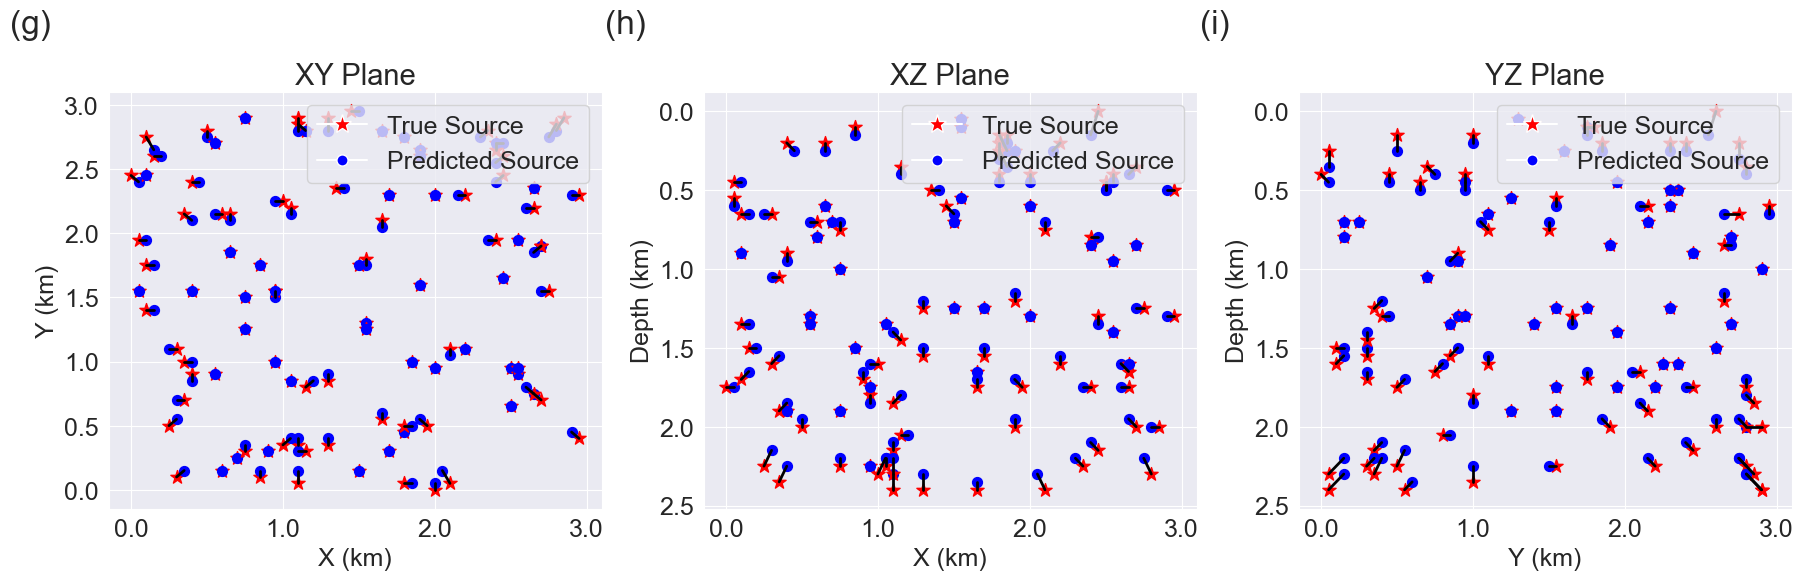

In [37]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os  # 确保导入os模块
import matplotlib.ticker as mticker

def plot_multiple_predictions(results, save=True, level_Code_id=3, show_fig=False):
    """
    可视化多个测试样本在 XY、XZ 和 YZ 平面上的位置。
    每个样本显示真实和预测的信号源位置，并用黑色实线连接。

    参数:
        results: 包含字典的列表，每个字典包含
                 'true_source_location' 和 'predicted_source_location',
                 均为 [x, y, z] 数组。
    """
    # 统一设置标签和标题样式
    label_style = {'fontsize': 18}
    title_style = {'fontsize': 21}
    legend_fontsize = 18

    # 创建一个包含三个子图的图形
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # 子图编号
    subplot_labels = ['(g)', '(h)', '(i)']

    # XY 平面（忽略 Z 轴）
    for res in results:
        true_src = res['true_source_location']
        pred_src = res['predicted_source_location']
        axs[0].scatter(true_src[0], true_src[1], color='red', marker='*', s=100)
        axs[0].scatter(pred_src[0], pred_src[1], color='blue', s=50)
        axs[0].plot([true_src[0], pred_src[0]], [true_src[1], pred_src[1]], color='black', linestyle='-', lw=2)
    axs[0].set_xlabel('X (km)', **label_style)
    axs[0].set_ylabel('Y (km)', **label_style)
    axs[0].set_title('XY Plane', **title_style)

    # XZ 平面（忽略 Y 轴）
    for res in results:
        true_src = res['true_source_location']
        pred_src = res['predicted_source_location']
        axs[1].scatter(true_src[0], true_src[2], color='red', marker='*', s=100)
        axs[1].scatter(pred_src[0], pred_src[2], color='blue', s=50)
        axs[1].plot([true_src[0], pred_src[0]], [true_src[2], pred_src[2]], color='black', linestyle='-', lw=2)
    axs[1].set_xlabel('X (km)', **label_style)
    axs[1].set_ylabel('Depth (km)', **label_style)
    axs[1].set_title('XZ Plane', **title_style)
    axs[1].invert_yaxis()

    # YZ 平面（忽略 X 轴）
    for res in results:
        true_src = res['true_source_location']
        pred_src = res['predicted_source_location']
        axs[2].scatter(true_src[1], true_src[2], color='red', marker='*', s=100)
        axs[2].scatter(pred_src[1], pred_src[2], color='blue', s=50)
        axs[2].plot([true_src[1], pred_src[1]], [true_src[2], pred_src[2]], color='black', linestyle='-', lw=2)
    axs[2].set_xlabel('Y (km)', **label_style)
    axs[2].set_ylabel('Depth (km)', **label_style)
    axs[2].set_title('YZ Plane', **title_style)
    axs[2].invert_yaxis()

    # 添加左上角编号
    for i, ax in enumerate(axs):
        ax.text(-0.2, 1.2, subplot_labels[i], transform=ax.transAxes,
                fontsize=24, va='top', ha='left')

    # 添加统一图例
    handles = [
        Line2D([0], [0], marker='*', color='w', label='True Source', markerfacecolor='red', markersize=14),
        Line2D([0], [0], marker='o', color='w', label='Predicted Source', markerfacecolor='blue', markersize=8),
    ]
    for ax in axs:
        ax.legend(handles=handles, fontsize=legend_fontsize, loc='upper right')

    # 增大坐标轴刻度字体
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=18)
        # 设置刻度格式
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

    plt.tight_layout()

    # 根据参数选择是否保存图片
    fig_filename = str(level_Code_id).split("_")[0]
    if save:
        save_dir = os.path.join("fig", f"fig_{fig_filename}_new")
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"Result_{level_Code_id}_2.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"切片图像已保存至: {save_path}")

    if show_fig:
        plt.show()

# 示例用法:
plot_multiple_predictions(test_results[0:100], save=True, level_Code_id=level_Code_id, show_fig=False)


Error distribution figure saved to: fig\fig_1_new\Error_Distribution_3.png


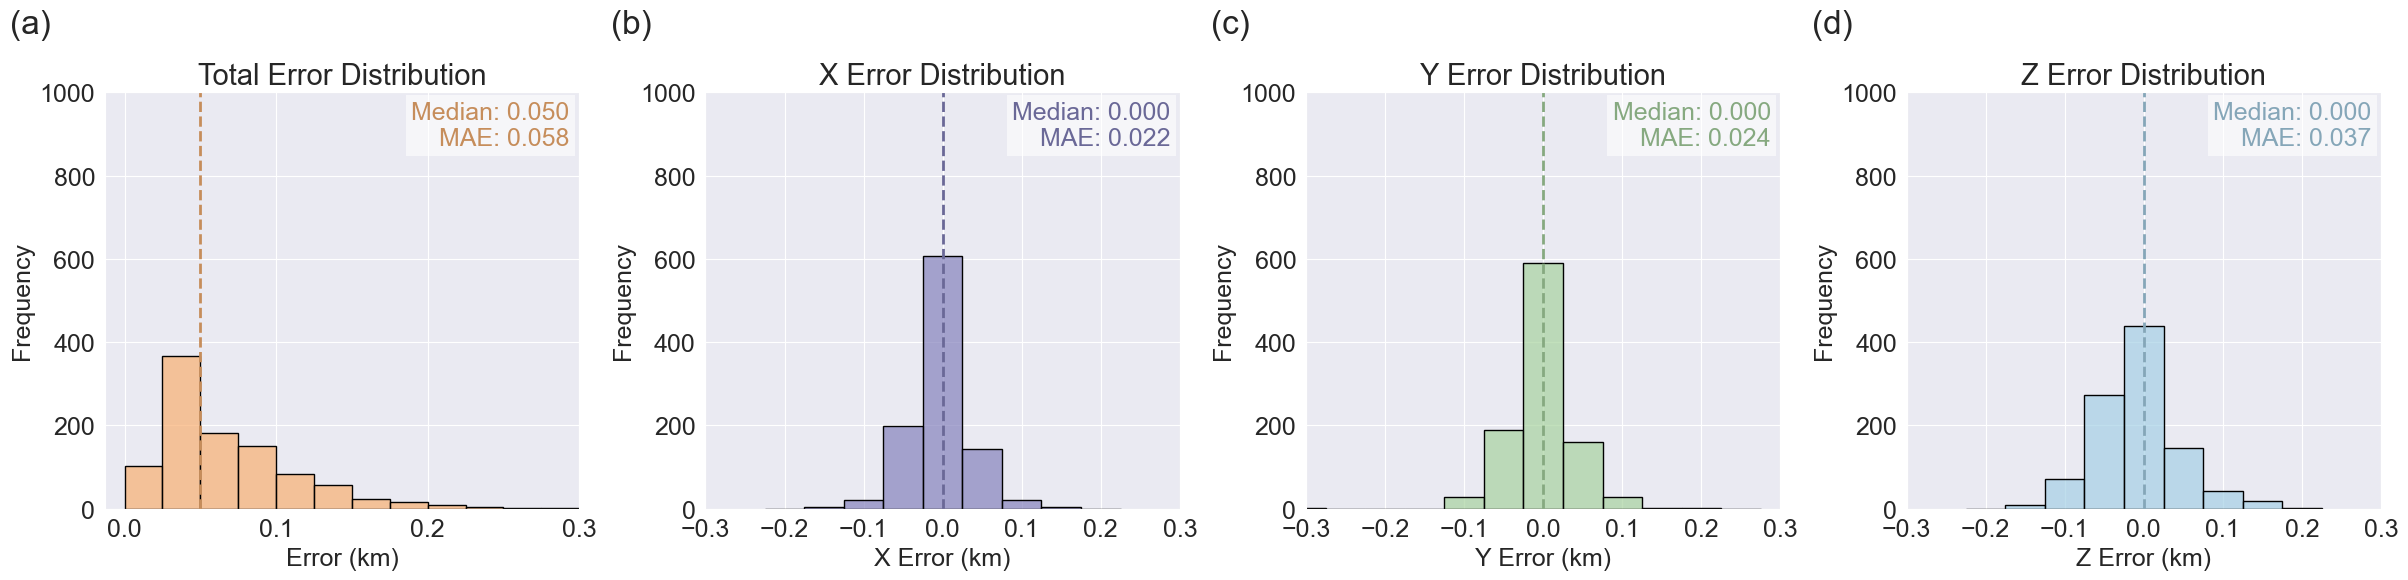

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.colors as mcolors

def darken_color(color, factor=0.8):
    rgb = mcolors.hex2color(color)
    dark_rgb = tuple(np.clip(c * factor, 0, 1) for c in rgb)
    return mcolors.to_hex(dark_rgb)

def assign_total_error_bin(x, bin_width=0.025):
    if np.isclose(x, 0, atol=1e-8) or np.isclose(x, 0.05, atol=1e-8):
        return np.random.choice([0.025, x])
    if np.isclose(x % bin_width, 0, atol=1e-8):
        return x
    else:
        lower = np.floor(x / bin_width) * bin_width
        upper = lower + bin_width
        return np.random.choice([lower, upper])

def get_bins(data, interval=0.05):
    min_val = data.min()
    max_val = data.max()
    min_center = np.floor(min_val / interval) * interval
    max_center = np.ceil(max_val / interval) * interval
    centers = np.arange(min_center, max_center + interval, interval)
    boundaries = [c - interval/2 for c in centers]
    boundaries.append(centers[-1] + interval/2)
    return np.array(boundaries)

def plot_error_distribution(test_results, save=False, code_id="ErrorDistribution", show_fig=True):
    label_style = {'fontsize': 18}
    title_style = {'fontsize': 21}
    legend_fontsize = 18
    total_count = len(test_results)

    actual_list = [np.array(res['true_source_location']) for res in test_results]
    predictions_list = [np.array(res['predicted_source_location']) for res in test_results]
    actual = np.array(actual_list)
    predictions = np.array(predictions_list)

    errors = predictions - actual
    total_error = np.linalg.norm(errors, axis=1)
    error_x, error_y, error_z = errors[:, 0], errors[:, 1], errors[:, 2]

    binned_total_error = np.array([assign_total_error_bin(x, 0.025) for x in total_error])
    total_bins = np.arange(0, binned_total_error.max() + 0.025, 0.025)
    bins_x = get_bins(error_x, 0.05)
    bins_y = get_bins(error_y, 0.05)
    bins_z = get_bins(error_z, 0.05)

    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    colors = ["#F8B072", "#8582BD", "#A8D3A0", "#A6D0E6"]
    titles = ["Total Error Distribution", "X Error Distribution", "Y Error Distribution", "Z Error Distribution"]
    xlabels = ["Error (km)", "X Error (km)", "Y Error (km)", "Z Error (km)"]
    subplot_labels = ["(a)", "(b)", "(c)", "(d)"]

    error_data = [binned_total_error, error_x, error_y, error_z]
    bin_data = [total_bins, bins_x, bins_y, bins_z]

    for i, ax in enumerate(axes):
        sns.histplot(error_data[i], bins=bin_data[i], kde=False, color=colors[i],
                     edgecolor='black', alpha=0.7, ax=ax)
        ax.set_title(titles[i], **title_style)
        ax.set_xlabel(xlabels[i], **label_style)
        ax.set_ylabel("Frequency", **label_style)

        median_val = np.median(error_data[i])
        mae_val = np.mean(np.abs(error_data[i]))
        ax.axvline(median_val, color=darken_color(colors[i]), linestyle='--', linewidth=2)
        ax.text(0.98, 0.98, f"Median: {median_val:.3f}\nMAE: {mae_val:.3f}",
                transform=ax.transAxes, ha='right', va='top', fontsize=legend_fontsize,
                color=darken_color(colors[i]), bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
        ax.text(-0.2, 1.2, subplot_labels[i], transform=ax.transAxes,
                fontsize=24, va='top', ha='left')

        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.set_ylim(0, total_count)
        if i==0:
            ax.set_xlim(-0.013, 0.3)  # 固定x轴范围
        else:
            ax.set_xlim(-0.3, 0.3)  # 固定x轴范围

    plt.tight_layout()

    if save:
        save_dir = os.path.join("fig", f"fig_{code_id}_new")
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"Error_Distribution_3.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Error distribution figure saved to: {save_path}")

    if show_fig:
        plt.show()


# 示例调用（确保 test_results 已定义）
plot_error_distribution(test_results, save=True, code_id=level_Code_id, show_fig=True)


C:\Users\zy18c\AppData\Local\Temp\ipykernel_12032\854355737.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


切片图像已保存至: fig\fig_1_new\travel_5.png


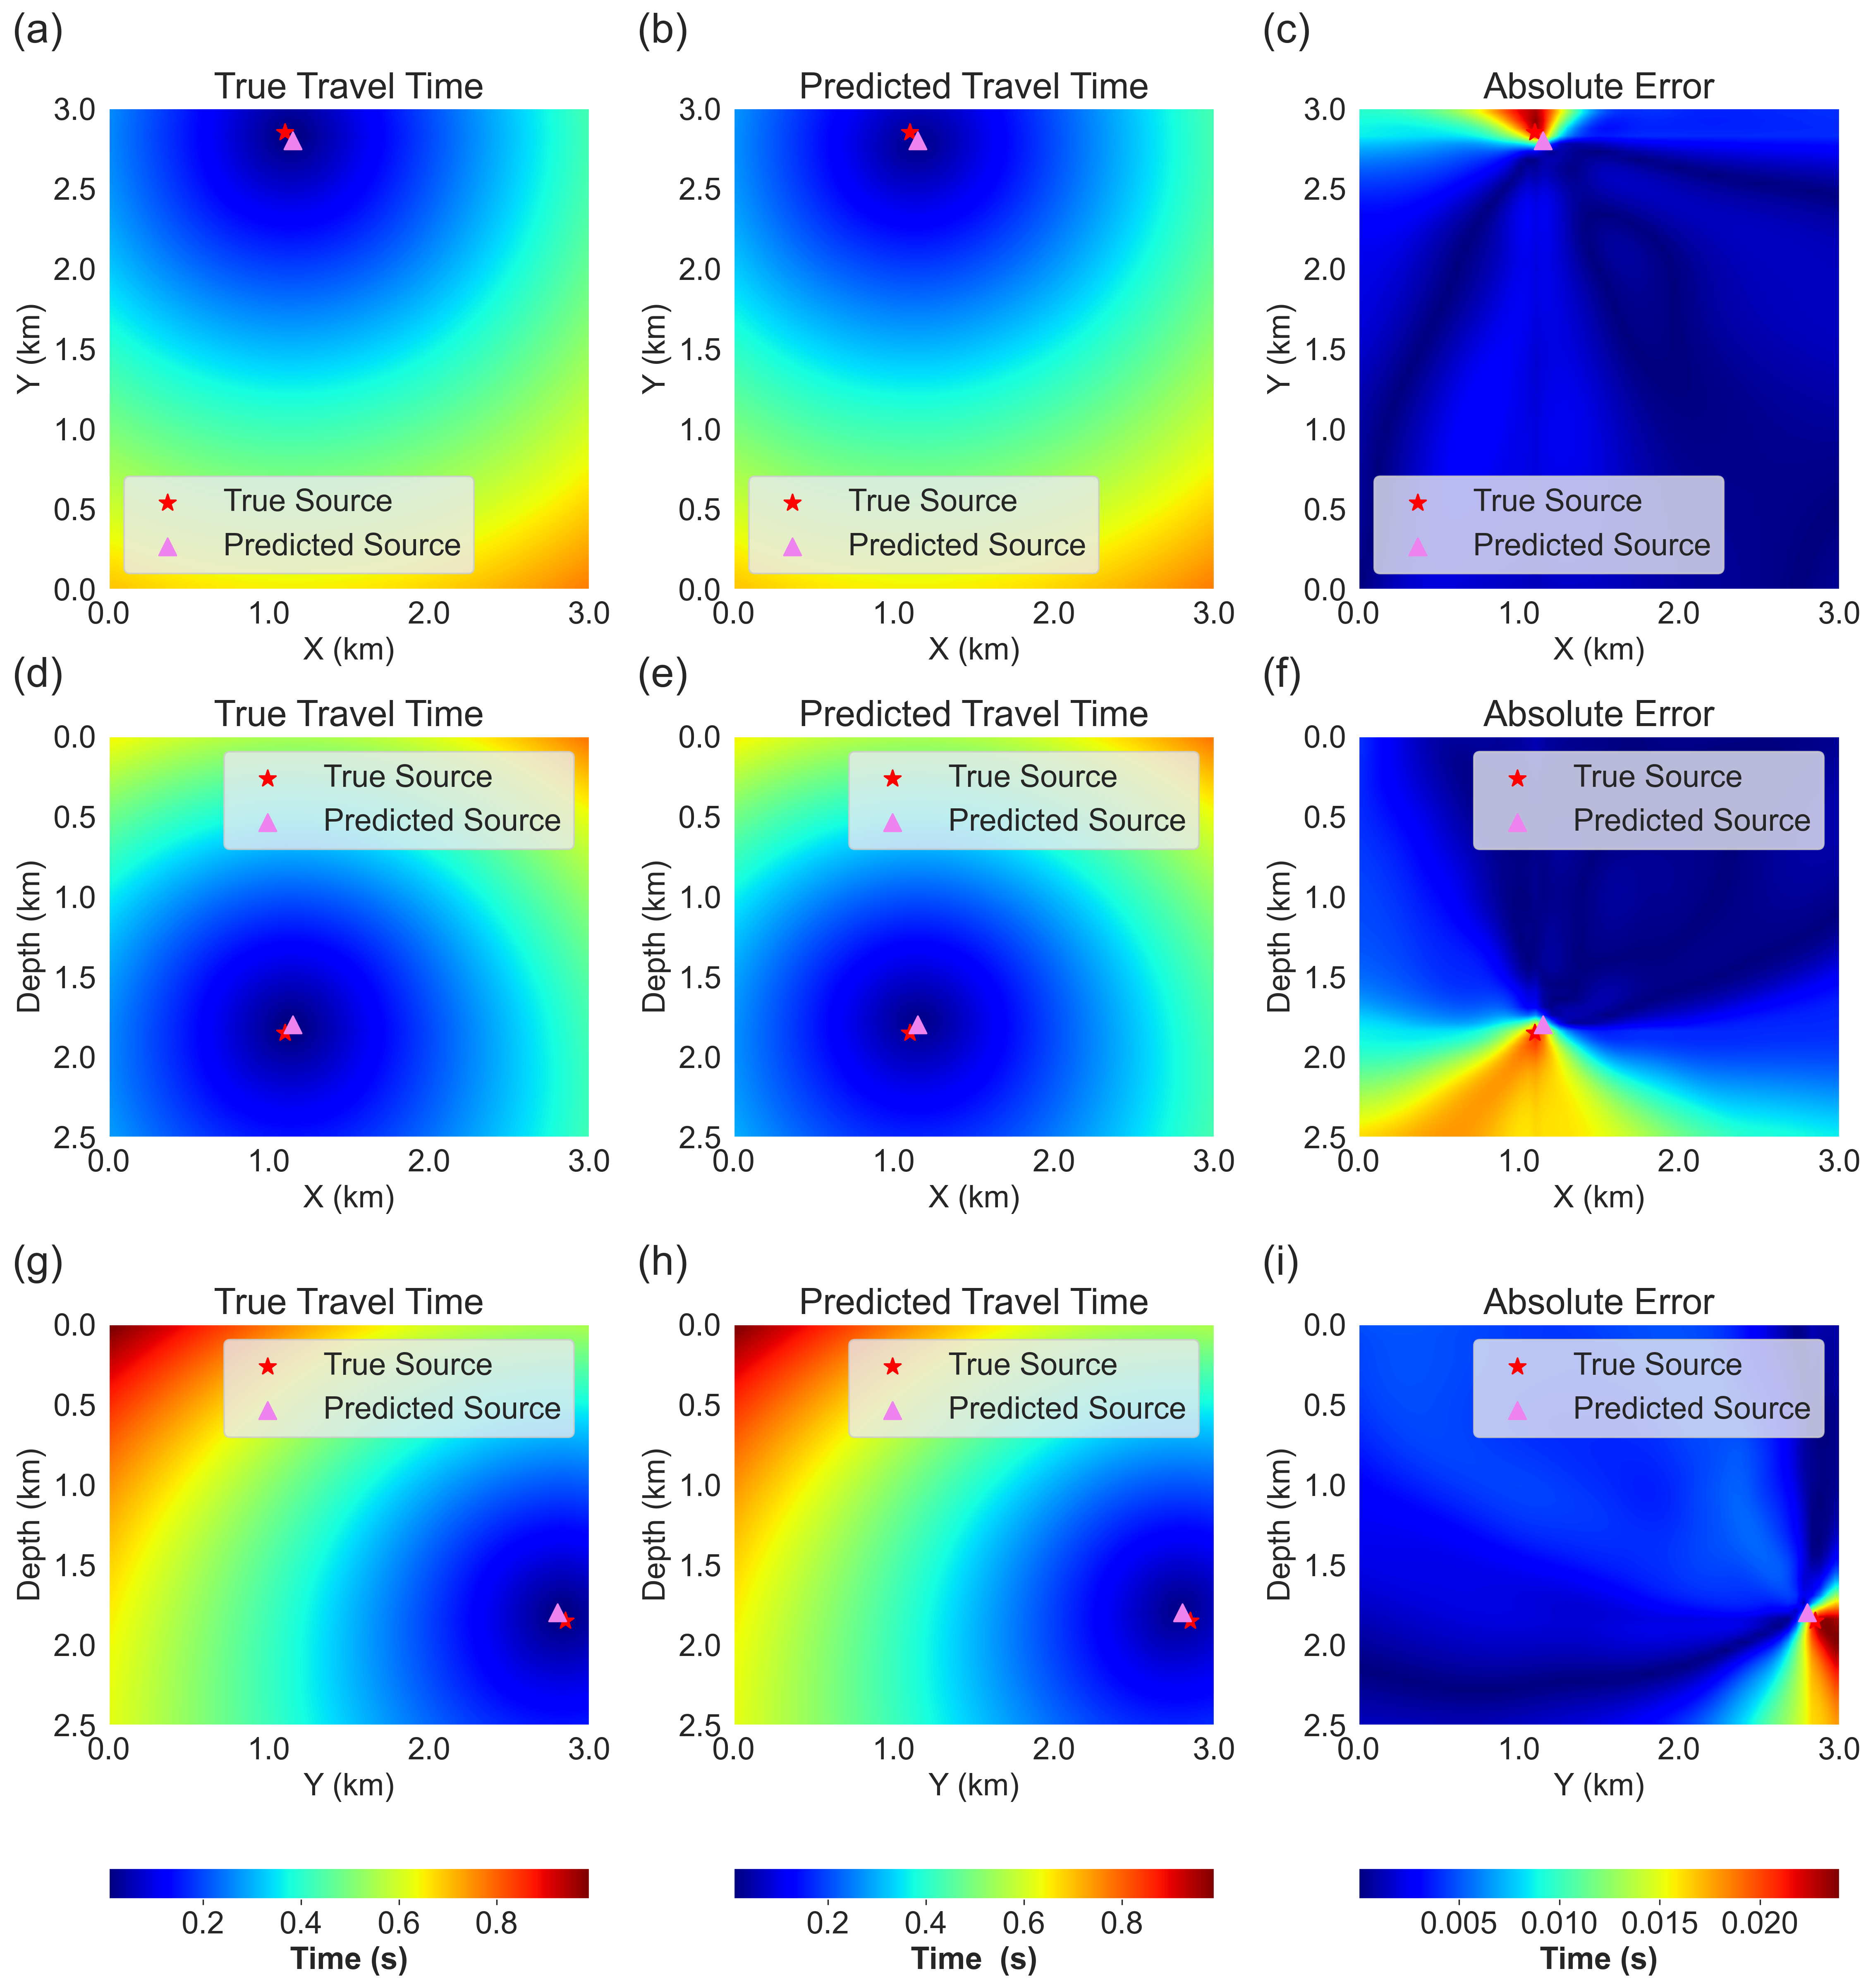

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
def visualize_three_slices_v1_1(result_dict, source_idx=0, save=False, code_id=3, show_fig=False):
    """
    采用jet色彩映射并自适应调整子图大小的三切片可视化，每列共享统一colorbar
    """
    label_style = {'fontsize': 18}
    title_style = {'fontsize': 21}
    legend_fontsize = 18

    grid_shape = result_dict['grid_shape']
    nx, ny, nz = grid_shape
    x_coords, y_coords, z_coords = map(np.array, [result_dict['x_coords'], result_dict['y_coords'], result_dict['z_coords']])

    def reshape_and_transpose(data):
        return data.reshape(grid_shape, order='F').transpose(2, 1, 0)

    true_tt_3d, pred_tt_3d, abs_error_3d = map(reshape_and_transpose,
        [result_dict['true_tt'], result_dict['pred_tt'], result_dict['abs_error']])

    src_x, src_y, src_z = result_dict['true_source_location']
    pred_source = result_dict['predicted_source_location']
    x_idx, y_idx, z_idx = map(lambda arr, v: np.argmin(np.abs(arr - v)),
                               [x_coords, y_coords, z_coords], [src_x, src_y, src_z])

    planes = [
        {"name": "XY", "extent": [x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]],
         "xlabel": "X (km)", "ylabel": "Y (km)", "true": true_tt_3d[z_idx], "pred": pred_tt_3d[z_idx], "err": abs_error_3d[z_idx],
         "true_loc": (src_x, src_y), "pred_loc": (pred_source[0], pred_source[1])},
        {"name": "XZ", "extent": [x_coords[0], x_coords[-1], z_coords[0], z_coords[-1]],
         "xlabel": "X (km)", "ylabel": "Depth (km)", "true": true_tt_3d[:, y_idx, :], "pred": pred_tt_3d[:, y_idx, :], "err": abs_error_3d[:, y_idx, :],
         "true_loc": (src_x, src_z), "pred_loc": (pred_source[0], pred_source[2])},
        {"name": "YZ", "extent": [y_coords[0], y_coords[-1], z_coords[0], z_coords[-1]],
         "xlabel": "Y (km)", "ylabel": "Depth (km)", "true": true_tt_3d[:, :, x_idx], "pred": pred_tt_3d[:, :, x_idx], "err": abs_error_3d[:, :, x_idx],
         "true_loc": (src_y, src_z), "pred_loc": (pred_source[1], pred_source[2])}
    ]

    data_types = [
        {"label": "True Travel Time", "key": "true", "cmap": "jet"},
        {"label": "Predicted Travel Time", "key": "pred", "cmap": "jet"},
        {"label": "Absolute Error", "key": "err", "cmap": "jet"}
    ]

    data_types_2 = [
        {"label": "Time (s)", "key": "true", "cmap": "jet"},
        {"label": "Time  (s)", "key": "pred", "cmap": "jet"},
        {"label": "Time (s)", "key": "err", "cmap": "jet"}
    ]

    # 预计算各数据类型的全局范围
    for dtype in data_types:
        combined_data = np.concatenate([plane[dtype['key']].flatten() for plane in planes])
        dtype['vmin'] = np.min(combined_data)
        dtype['vmax'] = np.max(combined_data)

    # 将第一列和第二列的色彩范围设置为公共范围
    common_vmin = min(data_types[0]['vmin'], data_types[1]['vmin'])
    common_vmax = max(data_types[0]['vmax'], data_types[1]['vmax'])
    data_types[0]['vmin'] = data_types[1]['vmin'] = common_vmin
    data_types[0]['vmax'] = data_types[1]['vmax'] = common_vmax

    # 创建图形布局，dpi设为300（如需更精细可增大dpi）
    fig = plt.figure(figsize=(18, 19), dpi=300)
    gs = gridspec.GridSpec(nrows=4, ncols=3, figure=fig,
                           height_ratios=[1, 1, 1, 0.1],
                           hspace=0.2, wspace=0.3)

    # 创建子图axes
    axes = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(3)]

    # 收集每列的im对象
    ims_per_column = [[] for _ in range(3)]

    # 绘制主图
    for i, plane in enumerate(planes):
        for j, dtype in enumerate(data_types):
            ax = axes[i][j]

            # 设置刻度格式
            ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
            # 使用 aspect='equal' 保证x和y的单位长度一致，并增加interpolation参数提高图像平滑度
            im = ax.imshow(
                plane[dtype['key']],
                extent=plane['extent'],
                origin='lower',
                aspect='equal',
                interpolation='bilinear',
                cmap=dtype['cmap'],
                vmin=dtype['vmin'],
                vmax=dtype['vmax']
            )
            ims_per_column[j].append(im)

            # 标记震源位置
            ax.scatter(*plane['true_loc'], c='red', marker='*', s=100, label='True Source')
            ax.scatter(*plane['pred_loc'], c='violet', marker='^', s=100, label='Predicted Source')

            # 反转深度轴
            if plane["name"] in ["XZ", "YZ"]:
                ax.invert_yaxis()

            # 设置标签（使用 label_style）
            ax.set_xlabel(plane['xlabel'], **label_style)

            # 仅第一列显示y轴标签
            if j == 0:
                ax.set_ylabel(plane['ylabel'], **label_style)
            else:
                # ax.set_ylabel('')
                # ax.yaxis.set_tick_params(labelleft=False)  # 隐藏刻度标签
                ax.set_ylabel(plane['ylabel'], **label_style)



            # 添加子图编号，将编号移到子图的左上角
            label_idx = i * 3 + j
            ax.text(-0.2, 1.2, f'({chr(97 + label_idx)})',
                    transform=ax.transAxes, ha='left', va='top',
                    fontsize=24)

            # # 设置标题（仅第一行），使用 title_style
            # if i == 0:
            #     ax.set_title(dtype['label'], **title_style)
            # ax.legend(fontsize=legend_fontsize, loc='upper right')

            ax.set_title(dtype['label'], **title_style)
            ax.legend(fontsize=legend_fontsize)

            # 增大坐标轴刻度字体
            ax.tick_params(axis='both', which='major', labelsize=18)

            # 移除网格线
            ax.grid(False)

    # 强制计算布局
    fig.tight_layout()
    plt.draw()

    # 创建调整后的colorbar
    cbar_axes = []
    for j in range(3):
        # 获取参考子图位置信息
        ref_ax = axes[0][j]
        ax_bbox = ref_ax.get_position()

        # 获取colorbar网格位置
        cbar_gs = gs[3, j]
        cbar_bbox = cbar_gs.get_position(fig)

        # 尺寸调整参数
        width_scale = 1
        height_scale = 0.6

        # 计算新尺寸
        new_width = ax_bbox.width * width_scale
        new_height = cbar_bbox.height * height_scale

        # 计算居中位置
        left = ax_bbox.x0 + (ax_bbox.width - new_width) / 2  # 水平居中
        bottom = cbar_bbox.y0 + (cbar_bbox.height - new_height) / 2  # 垂直居中

        # 创建colorbar坐标系
        cax = fig.add_axes([left, bottom, new_width, new_height])
        cbar_axes.append(cax)

    # 添加colorbar，并调整colorbar的刻度和标签字体
    for j in range(3):
        cb = fig.colorbar(
            ims_per_column[j][0],
            cax=cbar_axes[j],
            orientation='horizontal',
            label=data_types_2[j]['label']
        )
        cb.ax.tick_params(labelsize=18)
        # 设置colorbar label字体与x-label一致
        cb.ax.xaxis.label.set_fontsize(18)
        cb.ax.xaxis.label.set_fontweight('bold')
        cb.ax.xaxis.set_label_position('bottom')
        cb.ax.xaxis.set_ticks_position('bottom')
    # 保存图片
    fig_filename = str(code_id).split("_")[0]
    # 保存和显示
    if save:
        save_dir = os.path.join("fig", f"fig_{code_id}_new")
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"travel_5.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"切片图像已保存至: {save_path}")

    if show_fig:
        plt.show()
    else:
        plt.close()

    return fig

# 可视化第一个测试源的结果，并选择保存

visualize_three_slices_v1_1(test_results[0], source_idx=0, save=True, code_id=level_Code_id)


C:\Users\zy18c\AppData\Local\Temp\ipykernel_12032\3479206852.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cbar = fig.colorbar(contour, ax=ax, cmap=plt.cm.get_cmap('jet'), shrink=0.52, orientation='horizontal', pad=0.05, aspect=25)


图片已保存至：D:\DeskTop\PhysLoc-DeepONet\Try_zy - 副本\Try_zy_level\fig\fig_1_new/travel_time_4.png


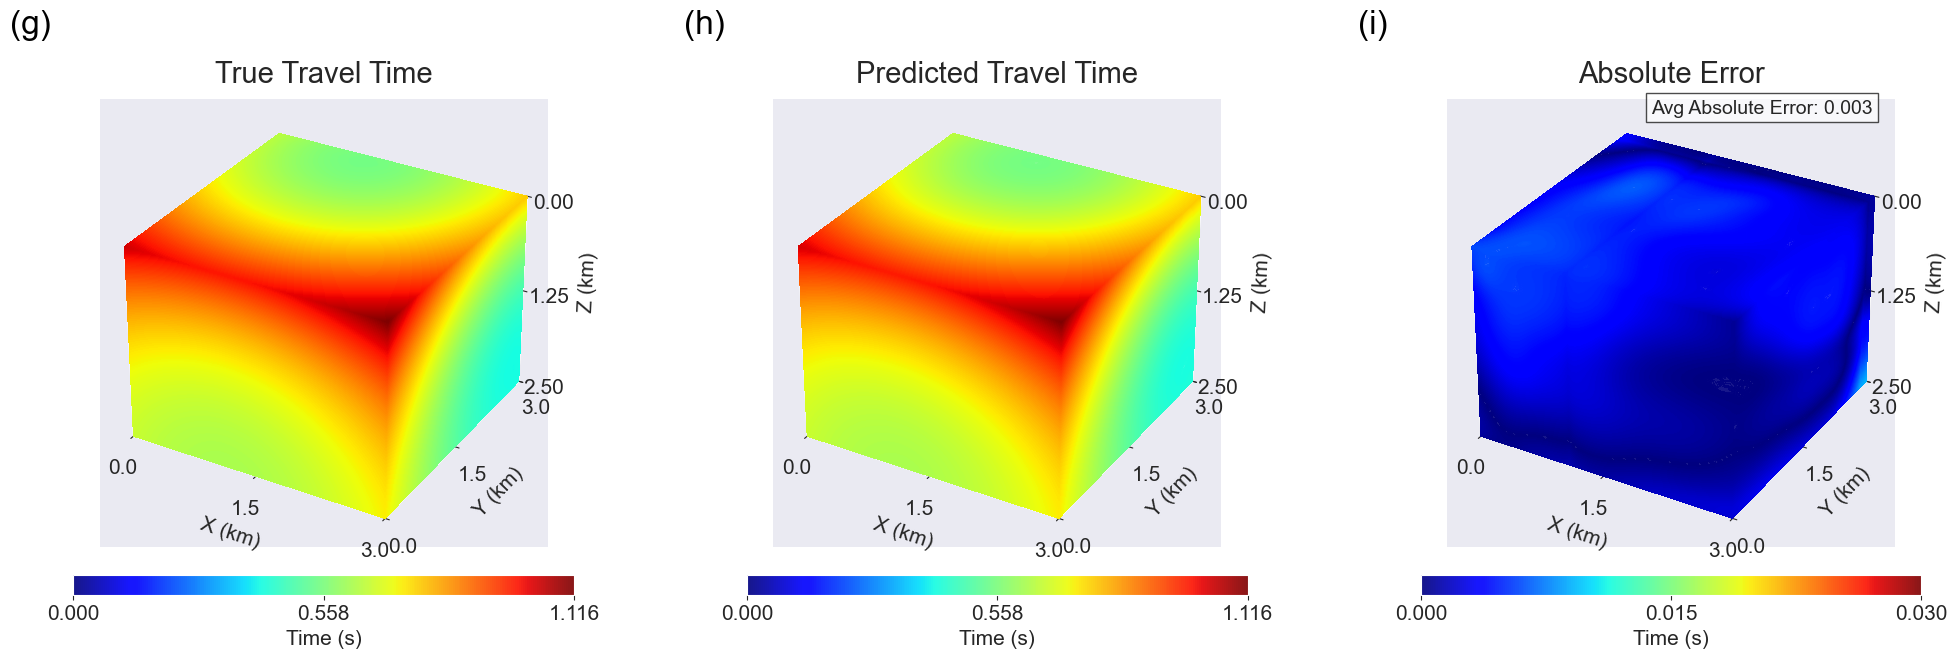

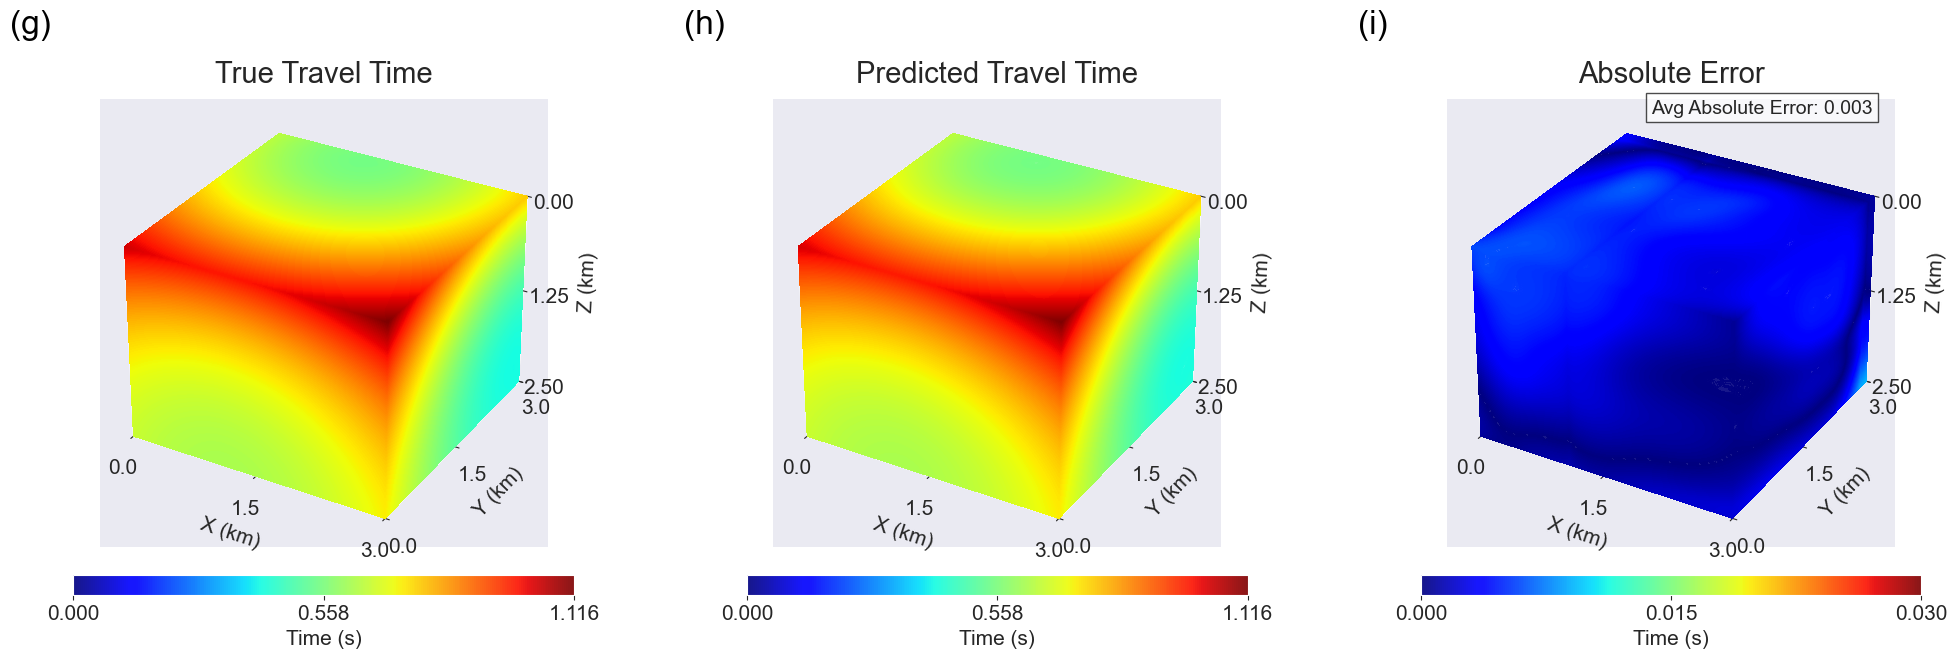

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
from mpl_toolkits.mplot3d import Axes3D

def visualize_three_slices_v2(result_dict, source_idx=0, levels=10, save=False,
                              alpha=0.5, level_Code_id=3, show_fig=False):
    """
    可视化三个正交切片的真实旅行时间、预测旅行时间和绝对误差，并使用3D轮廓图显示数据差异
    """
    # 数据准备
    grid_shape = result_dict['grid_shape']
    x_coords = result_dict['x_coords']
    y_coords = result_dict['y_coords']
    z_coords = result_dict['z_coords']

    # 数据重塑和转置
    true_tt_3d = result_dict['true_tt'].reshape(grid_shape, order='F').transpose(1, 0, 2)
    pred_tt_3d = result_dict['pred_tt'].reshape(grid_shape, order='F').transpose(1, 0, 2)
    abs_error_3d = np.abs(pred_tt_3d - true_tt_3d)


    # 创建3D网格
    X, Y, Z = np.meshgrid(x_coords, y_coords, z_coords, indexing='xy')

    # 可视化设置
    datasets = [true_tt_3d, pred_tt_3d, abs_error_3d]
    titles = ["True Travel Time", "Predicted Travel Time", "Absolute Error"]
    fig, axes = plt.subplots(1, 3, figsize=(22, 7), subplot_kw={'projection': '3d'})

    # 设置颜色标尺范围
    vmin, vmax = 0, max(np.max(true_tt_3d), np.max(pred_tt_3d))
    diff_vmin, diff_vmax = 0, 0.03


    # 计算 5 个等间距刻度
    def ticks(vmin, vmax, num=3):
        return np.linspace(vmin, vmax, num=3)
    #
    #
    # # 找到绝对误差的最大值
    # max_error_value = np.max(abs_error_3d)

    # 遍历每个子图
    for idx, (ax, data, title) in enumerate(zip(axes, datasets, titles)):
        current_kw = {
            'vmin': vmin if idx < 2 else diff_vmin,
            'vmax': vmax if idx < 2 else diff_vmax,
            'levels': np.linspace(vmin, vmax, levels) if idx < 2 else np.linspace(diff_vmin, diff_vmax, levels),
            'cmap': 'jet'
        }

        # 绘制三个正交切片
        ax.contourf(X[:, :, 0], Y[:, :, 0], data[:, :, 0], zdir='z', offset=Z.min(), alpha=alpha, **current_kw)
        ax.contourf(X[0, :, :], data[0, :, :], Z[0, :, :], zdir='y', offset=Y.min(), alpha=alpha, **current_kw)
        contour = ax.contourf(data[:, -1, :], Y[:, -1, :], Z[:, -1, :], zdir='x', offset=X.max(), alpha=alpha, **current_kw)

        # 坐标轴设置
        ax.set(xlim=(X.min(), X.max()), ylim=(Y.min(), Y.max()), zlim=(Z.max(), Z.min()),
               xlabel='X (km)', ylabel='Y (km)', zlabel='Z (km)')
        ax.dist = 11
        ax.tick_params(axis='both', which='major', labelsize=15)

        # 设置 5 个等间距刻度
        ax.xaxis.set_major_locator(plt.FixedLocator(ticks(X.min(), X.max())))
        ax.yaxis.set_major_locator(plt.FixedLocator(ticks(Y.min(), Y.max())))
        ax.zaxis.set_major_locator(plt.FixedLocator(ticks(Z.min(), Z.max())))

        # 轴标签设置
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)
        ax.zaxis.label.set_size(15)
        ax.xaxis.labelpad = 8
        ax.yaxis.labelpad = 8
        ax.zaxis.labelpad = 8
        ax.set_title(title, fontsize=21, pad=12)

        # 添加 colorbar
        cbar = fig.colorbar(contour, ax=ax, cmap=plt.cm.get_cmap('jet'), shrink=0.52, orientation='horizontal', pad=0.05, aspect=25)
        cbar.set_label('Time (s)', fontsize=15)
        cbar.ax.tick_params(labelsize=15)

        # 统一 colorbar 刻度
        cbar.set_ticks(ticks(diff_vmin if idx == 2 else vmin, diff_vmax if idx == 2 else vmax,num=5))
        cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        # plt.setp(cbar.ax.get_xticklabels(), rotation=-90)

        # 添加编号 (a)、(b)、(c)
        ax.text2D(-0.2, 1.2, f"({chr(103+idx)})", transform=ax.transAxes, fontsize=24, va='top', ha='left', color='black')
        # 计算平均误差
        mean_error_value = np.mean(abs_error_3d)

        # 在第三幅子图（绝对误差图）的右上角标注平均误差值
        if idx == 2:
            ax.text2D(
                0.95, 1, f'Avg Absolute Error: {mean_error_value:.3f}',
                transform=ax.transAxes, fontsize=14,
                ha='right', va='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
            )



        # # 在第三幅子图（绝对误差图）的右上角标注最大误差值
        # if idx == 2:
        #     ax.text2D(
        #         0.95, 1, f'Max Absolute Error: {max_error_value:.3f}',
        #         transform=ax.transAxes, fontsize=14,
        #         ha='right', va='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
        #     )

    # 调整布局
    plt.subplots_adjust(left=0.05, right=1.1, top=0.90, bottom=0.10, wspace=-0.3)

    # 保存图片
    if save:
        save_dir = f"./fig/fig_{level_Code_id}_new"
        os.makedirs(save_dir, exist_ok=True)
        filename = f"travel_time_4.png"
        plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
        print(f"图片已保存至：{os.path.abspath(save_dir)}/{filename}")

    if show_fig:
        plt.show()

    return fig

# 使用示例（请确保 test_results 已经定义）

visualize_three_slices_v2(
    test_results[0],
    source_idx=0,
    levels=10000,
    save=True,
    alpha=0.9,
    level_Code_id=level_Code_id,
    show_fig=True
)
